## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

import feather

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
universe_raw = feather.read_dataframe('factor_data/bitcon_zscore.feather')
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y-%m-%d %H:%M:%S')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(78239, 20)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[(universe['trade_date']>='2022-06-01') & (universe['trade_date']<='2023-03-29')]
universe.columns

Index(['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume', 'vwap',
       'trade_date', 'alpha_kama2', 'alpha_wt', 'alpha_026', 'alpha_018',
       'alpha_044', 'alpha_131', 'alpha_cci', 'alpha_rsi', 'alpha_kama',
       'alpha_ccix', 'alpha_atr'],
      dtype='object')

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [ ]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date 
                # 'log-ret' 'open', 'high', 'low', 'close', 'volume', 'vwap',
                # 'alpha_kama2', 'alpha_wt', 'alpha_026', 'alpha_018', alpha_044', 
                # ''alpha_131', 'alpha_cci', 'alpha_rsi', 'alpha_kama', 'alpha_ccix'
                data = [pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S'), ticker, dt,
                       0., 0., 0., 0., 0., 0., 0.,
                       0., 0., 0., 0., 0., 
                       0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date', 'ts_code']) 
    return df

universe = init_holding(universe)

### Rescale AI Factor

In [ ]:
def rescale_(data):
    # resize from -1 to 1
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    max_val = data[feature].median() + 3.3*data[feature].std()
    min_val = data[feature].median() - 3.3*data[feature].std()
    data[feature] = np.where(data[feature]>max_val, max_val, 
                           np.where(data[feature]<min_val, min_val, data[feature]))
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                             np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

#universe_z = universe.groupby('trade_date').apply(rescale_)
universe_z = universe.groupby('trade_date')[universe.columns].apply(rescale_)

In [ ]:
print(universe_z['alpha_AI'].median())
universe_z['alpha_AI'].hist()

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [4]:
universe['alpha_026'] = -universe['alpha_026']
#universe['alpha_atr'] = -universe['alpha_atr']

In [5]:
## shif return 5 days
all_factors = universe.copy(deep=True)
#all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-1)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(65045, 20) (65045, 21)


In [6]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']=='2022-07-01 00:00:00'])

alpha_kama2   -0.000524
alpha_wt      -0.001857
alpha_026      0.004138
alpha_018     -0.002982
alpha_044      0.001306
alpha_131     -0.000698
alpha_cci      0.002193
alpha_rsi     -0.002365
alpha_kama     0.001846
alpha_ccix    -0.002193
alpha_atr      0.003316
dtype: float64

In [7]:
base_field = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume', 'vwap','trade_date']
alpha_field = [
       'alpha_wt', 'alpha_026', 'alpha_018', 'alpha_044', 'alpha_rsi', 'alpha_atr'
        ] 
date_and_code = [ 'ts_code', 'returns_2']

start_time = '2022-07-01 00:00:00'
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df.index>=start_time]
calendar = alpha_df.index.unique() # int64

#only for positive estimate
# for feature in alpha_field:
#     alpha_df[feature] = np.where(alpha_df[feature]>=0.7, alpha_df[feature], np.where(alpha_df[feature]<=-0.7, alpha_df[feature], 0))
#     alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df.index==dt])
facret[calendar[-5]]

regression factor returns: 100%|████████████| 1627/1627 [00:52<00:00, 30.93it/s]


alpha_wt     0.001760
alpha_026    0.006520
alpha_018    0.000205
alpha_044    0.002501
alpha_rsi    0.003436
alpha_atr    0.003188
dtype: float64

#### Veiw Factor Returns

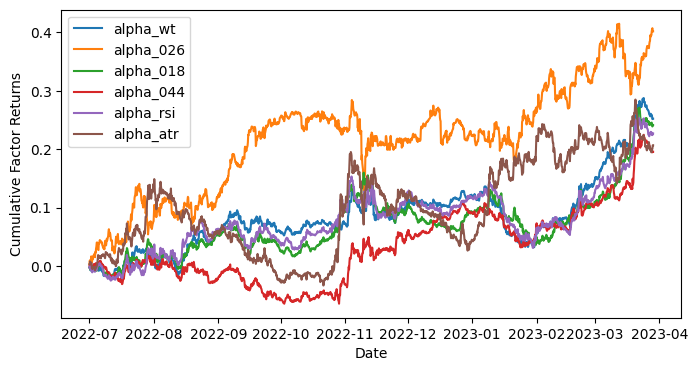

In [8]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [9]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=180):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [10]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
#     for col in returns_df.columns:
#         returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 5
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector, F

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i, F = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 180
return date 2022-07-01T00:00:00.000000000


ts_code,1000SHIBUSDT,ADAUSDT,ALGOUSDT,APEUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,C98USDT,...,NEARUSDT,OMGUSDT,OPUSDT,RENUSDT,SANDUSDT,SOLUSDT,SXPUSDT,TOMOUSDT,XLMUSDT,XRPUSDT
ts_code,,,,,,,,,,,,,,,,,,,,,
1000SHIBUSDT,0.154265,0.091308,0.084975,0.108733,0.099191,0.119005,0.073250,0.076415,0.068068,0.085487,...,0.107658,0.089568,0.153596,0.105214,0.115227,0.124590,0.089908,0.099447,0.078408,0.068872
ADAUSDT,0.091308,0.127046,0.090752,0.137932,0.099131,0.124793,0.073870,0.077270,0.068121,0.104881,...,0.117667,0.095332,0.145497,0.136115,0.115714,0.130084,0.096958,0.104769,0.080479,0.069773
ALGOUSDT,0.084975,0.090752,0.099168,0.121796,0.092078,0.114501,0.066746,0.070677,0.062610,0.094742,...,0.106771,0.087984,0.113832,0.121103,0.105559,0.118716,0.090227,0.096267,0.073883,0.063777
APEUSDT,0.108733,0.137932,0.121796,0.236781,0.129352,0.165951,0.101342,0.104106,0.091822,0.133694,...,0.158079,0.126334,0.202395,0.204354,0.152342,0.175997,0.127308,0.138514,0.108217,0.093921
ATOMUSDT,0.099191,0.099131,0.092078,0.129352,0.127865,0.126832,0.073666,0.077853,0.068609,0.104964,...,0.117928,0.096467,0.131817,0.126070,0.118410,0.130194,0.098885,0.105478,0.081546,0.070710


In [11]:
h=np.array([1/36]*36) 
(np.dot(h, variance_i).dot(h.T))** 0.5

0.3283295398622175

In [12]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i, F = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:], residual_i.copy(), F]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 180
(58572, 3) (58572, 22)


### (Optional) Store Residual

In [ ]:
#universe = universe.merge(residual_df, on=['ts_code', 'trade_date'], how='left')
#universe = universe.rename(columns={'residual': 'alpha_resi'})
#universe = universe.loc[universe['trade_date']>=start_time]

In [ ]:
#universe['alpha_resi'].hist()

In [ ]:
# universe['alpha_resi'] = universe['alpha_resi'] * 1000
# universe.to_csv('AI_data/factors_AI_108_residual.csv')

### Combine Factors

In [13]:
#'alpha_atr14', 'alpha_kama', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y-%m-%d %H:%M:%S')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['ts_code'])
alpha_df['alpha_all'] = alpha_df['alpha_026']
#alpha_df['alpha_all'] = 0.35*alpha_df['alpha_kama'] + 0.65*alpha_df['alpha_009']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

3.3886645826543105 -3.4679230295271974


In [ ]:
# for dt in alpha_df.index.get_level_values(0)[-200:]:
#     tmp = alpha_df.loc[dt]
#     print(tmp['trade_date'])

### Backtest by Convex Optimization(Choice one option)

### Option One
- use `cvxpy` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed max risk to endure

In [14]:
calendar = alpha_df.trade_date.unique()
ticker_num = len(alpha_df.index.get_level_values(1).unique())

# get parameter
positions = {}
alpha_df['h_privious'] = 0.
h0 = [0.] * ticker_num
aversion = 0.1
Lambda = 1e-3

In [ ]:
#dt = np.datetime64('2022-07-01 00:00:00.000000000')
#variance_all[dt][3]
#list(variance_all.keys())

In [15]:
from helper.project_helper import OptimalHoldings

dt = np.datetime64('2022-07-01 00:00:00.000000000')
obj_df = alpha_df.loc[alpha_df.trade_date==dt]
alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
optimal_weights = OptimalHoldings(aversion=.1, weights_max=0.25, weights_min=-0.25, lambda_reg=0.01).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'], Lambda = Lambda ** 2)
optimal_weights.loc[optimal_weights[0]<=-0.01]

,0
ts_code,
BTCUSDT,-0.25
ETHUSDT,-0.25


In [16]:
for dt in tqdm(calendar, desc='optimized holding...'):
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
    # convex optimize
    optimal_weights = OptimalHoldings(aversion=.1, weights_max=0.25, weights_min=-0.25, lambda_reg=0.01).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'],Lambda = 2e-6)
    h_optimal = optimal_weights
    # update optimize holding
    obj_df['h_opt'] = h_optimal.values
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal.values

optimized holding...: 100%|█████████████████| 1627/1627 [07:10<00:00,  3.78it/s]


### Option Two
- use `scipy.optimize.fmin_l_bfgs_b` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk 1 posistion map to reduce how much risk

In [ ]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * (np.dot(h, variance).dot(h.T)) \
             + np.dot((h-h0)**2, Lambda) \
             + 0.1 * alpha * np.linalg.norm(h) \
             #+ sum(h) ** 2
             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) \
                + 0.2 * alpha
                #+ 2 * h
        return f_hat
    return grad_func

# get parameter
bounds = [(0, 10000)] * ticker_num

# for dt in calendar:
#     # fill yesterday holding
#     obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
#     # convex optimize
#     obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
#     #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
#     # update optimize holding
#     obj_df['h_opt'] = h_optimal
#     obj_df['h_privious'] = h0
#     positions[dt]= obj_df
#     h0 = h_optimal

2.446508813549751e-12 -1.451935724014819e-12
-3.2720320288226275e-16 4.65363892012539e-17


<AxesSubplot:>

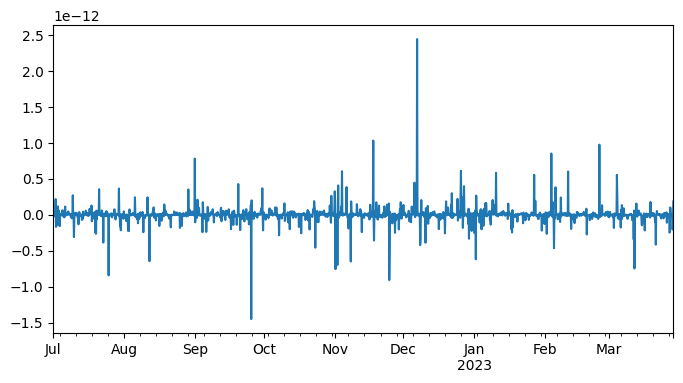

In [17]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [18]:
holding_money = 1e5
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt'] * holding_money
    positions[i]['h_privious'] = positions[i]['h_privious'] * holding_money

In [19]:
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [20]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

2.4464371997237714e-07 -1.4517806658263093e-07


In [27]:
tmp

log-ret          open          high           low  \
date       ts_code                                                       
2023-03-29 BTCUSDT  0.015707  26984.800781  27500.000000  26720.300781   
           ETHUSDT  0.024052   1742.989990   1797.189941   1724.400024   

                           close        volume          vwap trade_date  \
date       ts_code                                                        
2023-03-29 BTCUSDT  27412.099609  1.511338e+05  27210.798828 2023-03-29   
           ETHUSDT   1785.430054  1.150678e+06   1769.006714 2023-03-29   

                    alpha_kama2  alpha_wt  ...  alpha_131  alpha_cci  \
date       ts_code                         ...                         
2023-03-29 BTCUSDT    -1.091928 -1.539426  ...  -2.445046  -0.543257   
           ETHUSDT    -0.018569  0.897347  ...  -1.747815  -0.235196   

                    alpha_rsi  alpha_kama  alpha_ccix  alpha_atr  residual  \
date       ts_code                                                           
2023-03-29 BTCUSDT  -0.713935    1.006486    0.543257  -1.220281  0.009996   
           ETHUSDT   1.036431    0.492860    0.235196  -0.809723  0.006019   

                    alpha_all    h_privious         h_opt  
date       ts_code                                         
2023-03-29 BTCUSDT   3.150701  3.700612e-07  24999.999999  
           ETHUSDT   0.722700  2.500000e+04  24999.999998  

[2 rows x 23 columns]

49999.99999752573 (10, 23)


close   log-ret    h_privious         h_opt
date       ts_code                                                     
2023-03-29 BTCUSDT   27412.099609  0.015707  3.700612e-07  24999.999999
           C98USDT       0.212600  0.021874 -5.263494e-07  -3675.287819
           CELOUSDT      0.604000  0.015013 -4.687865e-07  -2879.774161
           ETHUSDT    1785.430054  0.024052  2.500000e+04  24999.999998
           FTMUSDT       0.426600  0.028291 -4.733950e-07  -2908.297535
           GALAUSDT      0.039360  0.020275 -2.500000e+04 -13916.219305
           GMTUSDT       0.375300  0.023454 -1.164437e-06  -8207.459073
           LINAUSDT      0.009640  0.038060 -9.621510e-07  -7233.831809
           OPUSDT        2.245700  0.037660 -1.099977e-06  -3616.644369
           SANDUSDT      0.615100  0.017880 -1.007934e-06  -7468.992635

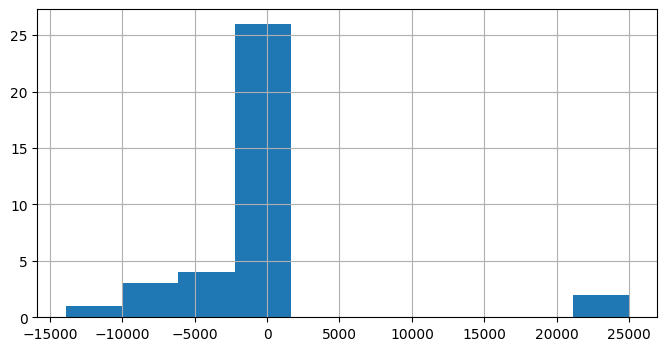

In [30]:
date_hold = list(positions.keys())[-1]
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[(positions[date_hold]['h_opt']>1000) | (positions[date_hold]['h_opt']<-1000)]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

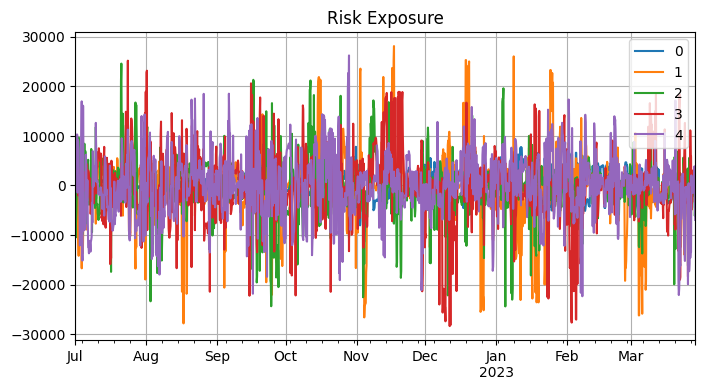

In [31]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

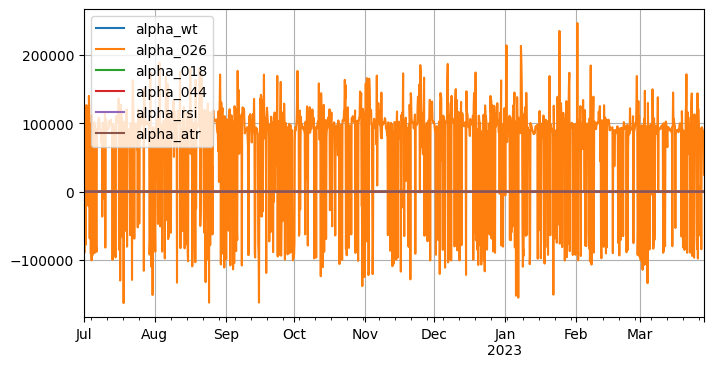

In [33]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_wt', 'alpha_026', 'alpha_018', 'alpha_044', 'alpha_rsi', 'alpha_atr', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0., 1., 0., 0., 0., 0.]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=[
                    'alpha_wt', 'alpha_026', 'alpha_018', 'alpha_044', 'alpha_rsi', 'alpha_atr'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

1138.5746932063605 -50000.000000172644


<AxesSubplot:>

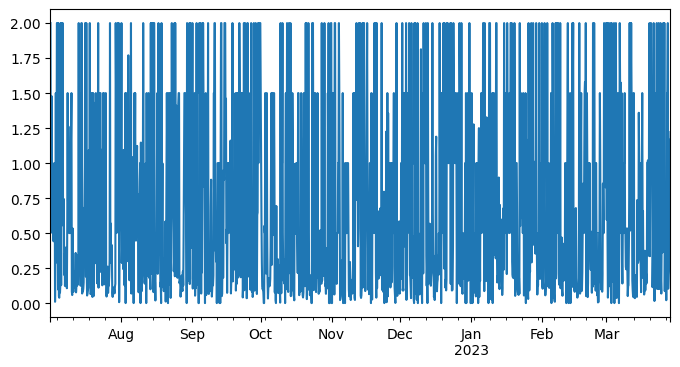

In [35]:
transaction_costs = []
retre_max = 0
Lambda = 1e-10
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    if min(tmp_change)<retre_max:
        retre_max = min(tmp_change)
    costs = sum(np.dot(tmp_change**2, Lambda)**0.5)
    transaction_costs.append(costs)
print(sum(transaction_costs),retre_max)
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Cal BenchMark

In [ ]:
benchmark_return = pd.read_csv('AI_data/benmark_AI_119.csv')
benchmark_return.columns = ['trade_date', 'log-ret']
benchmark_return.tail()

### Profit-and-Loss (PnL)

2023-03-28 08:00:00


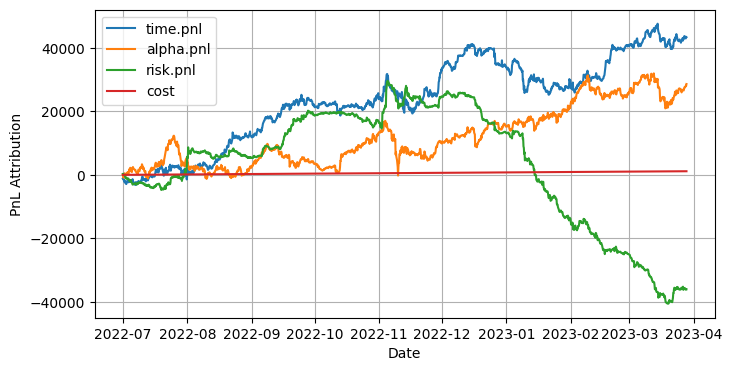

In [40]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[pd.Timestamp(dt)].loc[['alpha_wt', 'alpha_026', 'alpha_018', 'alpha_044', 'alpha_rsi', 'alpha_atr']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"cost"] = transaction_costs[ii]
        #df.at[time_i,"benchmark.pnl"] = positions[dt]['h_opt'].sum() * \
                            #benchmark_return.loc[benchmark_return.trade_date==dt]['log-ret'].values[0]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
plt.grid(True)
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [41]:
attr['time.pnl'].sum()

43336.57414082869

In [42]:
attr['time.pnl'].cumsum().min()

-3109.8777726118637

In [44]:
attr['alpha.pnl'].sum()

28587.189296490684

In [38]:
list(facret.keys())[0]

Timestamp('2022-07-01 00:00:00')